In [4]:
# Numerics
import qutip as qt
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from IPython.display import Image

# Tracking info of simulations
import tqdm
import time
import warnings

#Saving data
import pandas as pd
import json
import os
import csv

# Suppress DeprecationWarning
warnings.filterwarnings('ignore', category=FutureWarning)

In [5]:
#Pauli matrices
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()
#Identity
I = qt.qeye(2)
#sigma+-
sm = qt.destroy(2)
sp = qt.create(2)

ket0 = qt.basis(2, 0)
ket1 = qt.basis(2, 1)

In [6]:
def initialize_general_system(size, alice_register): # alice_register is already in domain wall encoding
    #initialize chain
    #check that initial state is a valid one
    if abs(1 - abs(alice_register.dag()*alice_register)) > 0.0001:
        print("Initial state is not valid")
        return
    
    alice_reg_len = len(alice_register.dims[0])
    #check that chain is long enough to do transport
    if alice_reg_len*2 >= size:
        print("Chain too short to transport initial state")
        return
     
    chain = [qt.basis(2, 0)]*(size - alice_reg_len)
    chain_state = qt.tensor(chain)

    #Total state is product state of spins
    initial_state = qt.tensor(alice_register, chain_state) 
    
    return initial_state

def generate_target(size, bob_register): 
    #check that final state is a valid one
    if abs(1 - abs(bob_register.dag()*bob_register)) > 0.0001:
        print("Initial state is not valid")
        return
    
    bob_reg_len = len(bob_register.dims[0])
    #check that chain is long enough to do transport
    if bob_reg_len*2 >= size:
        print("Chain too short to transport initial state")
        return
     
    chain = [qt.basis(2, 0)]*(size - bob_reg_len)
    chain_state = qt.tensor(chain)

    #Total state is product state of spins
    final_state = qt.tensor(chain_state, bob_register) 
    
    return final_state

In [7]:
def crate_domain_wall_state(state_dictionary):
    # example: |psi> = ["001":0.4,"101":0.2,"111":0.6,"110":0.35]
    state = 0
    for i, term in enumerate(state_dictionary.keys()):
        dw_spins = []
        #first bit is always a down wire qubit
        last_spin = "0"
        #reverse order and loop over bits
        for bit in term[::-1]:
            #put 0 or 1 to create (or not) domain wall
            if bit == "1":
                if last_spin == "0":
                    dw_spins.append(ket1)
                    last_spin = "1"
                elif last_spin == "1":
                    dw_spins.append(ket0)
                    last_spin = "0"
            elif bit == "0":
                if last_spin == "0":
                    dw_spins.append(ket0)
                    last_spin = "0"
                elif last_spin == "1":
                    dw_spins.append(ket1)
                    last_spin = "1"
        #reverse order of list again and make tensor product
        dw_term = qt.tensor(dw_spins[::-1])
        #add to full state with corresponding weight
        state += state_dictionary[term]*dw_term
    # normalize
    norm = np.sqrt(state.dag()*state)
    return state/norm


def create_domain_wall_target(state_dictionary):
    # example: |psi> = ["001":0.4,"101":0.2,"111":0.6,"110":0.35]
    state = 0
    for i, term in enumerate(state_dictionary.keys()):
        dw_spins = []
        #first bit is always a down wire qubit
        last_spin = "0"
        #loop over bits (w/o reversing order this time)
        for bit in term:
            #put 0 or 1 to create (or not) domain wall
            if bit == "1":
                if last_spin == "0":
                    dw_spins.append(ket1)
                    last_spin = "1"
                elif last_spin == "1":
                    dw_spins.append(ket0)
                    last_spin = "0"
            elif bit == "0":
                if last_spin == "0":
                    dw_spins.append(ket0)
                    last_spin = "0"
                elif last_spin == "1":
                    dw_spins.append(ket1)
                    last_spin = "1"
        #reverse order of list and make tensor product
        dw_term = qt.tensor(dw_spins[::-1])
        #add to full state with corresponding weight
        state += state_dictionary[term]*dw_term
    # normalize
    norm = np.sqrt(state.dag()*state)
    return state/norm
        

In [8]:
#Define the coupling values
def J_definition(size, factor):
    strengths = np.zeros(size)
    for i in range(0,size):
        strengths[i] = 0.5*factor*np.sqrt((i+1)*(size-i))
    return strengths

#couplings in domain wall
def tn_definition(data_j):
    size = len(data_j)
    out = np.zeros(size)
    for i in range(size):
        out[i] = -data_j[i]
    return out

In [9]:
def Initialize_Hamiltonian(n_spins):    
# Setup operators for individual qubits
    sx_list, sy_list, sz_list = [], [], []
    #for each value of i it puts the paulis in different positions of the list, then does IxIxI...sigma_ixIxI...xI
    for i in range(n_spins):
        #list of 2x2 identity matrices
        op_list = [qt.qeye(2)] * n_spins
        #replace i-th element with sigma_x
        op_list[i] = sx
        #create matrices of 2^Nx2^N
        sx_list.append(qt.tensor(op_list))
        #do the same for sigma_y and sigma_z
        op_list[i] = sy
        sy_list.append(qt.tensor(op_list))
        op_list[i] = sz
        sz_list.append(qt.tensor(op_list))

    return sx_list, sy_list, sz_list

def  Hamiltonian_forward(n_spins, J_global, t_couplings, sx_list, sy_list, sz_list):
    Ham = 0
    #Transverse field but not in first spin
    for i in range(1, n_spins):
        Ham += -t_couplings[i-1] * sx_list[i]
        # print("Transverse field on spin", i, "=", t_couplings[i-1])

    #Virtual qubit down at end of chain
    Ham+= +J_global*sz_list[n_spins-1]

    #Interaction terms with the rest of the spins
    for i in range(0, n_spins-1):
        Ham += J_global* sz_list[i]*sz_list[i+1]

    return Ham

def  Hamiltonian_backward(n_spins, reg_size, J_global, t_couplings, sx_list, sy_list, sz_list):
    Ham = 0
    #Transverse field but not in Bob's register
    for i in range(0, n_spins - reg_size):
        Ham += -t_couplings[i] * sx_list[i]
        # print("Transverse field on spin", i, "=", t_couplings[i])

    #Virtual qubit down at start of chain
    Ham += +J_global*sz_list[0]
    #Ham+= +J_global*sz_list[n_spins-1]

    #Interaction terms with the rest of the spins
    for i in range(0, n_spins-1):
        Ham += J_global* sz_list[i]*sz_list[i+1]

    return Ham

In [10]:
def time_evolution(Ham, sigma_z_list,  initial_state, initial_time, final_time, timesteps): 
    times = np.linspace(initial_time, final_time, timesteps)
    #apply hamiltonian to initial state and don't track any observables
    options = {
    'method': 'adams', 
    'progress_bar': 'tqdm'
}
    simulation_results = qt.sesolve(Ham, initial_state, times, options = options)

    print("Simulated evolution from time", initial_time, "to", final_time, "in", timesteps, "steps \n")

    return simulation_results

In [11]:
def calculate_full_fidelity(n_spins, state_evolution, target_state = None): 
    #Calculate fidelities and find maximum
    if target_state is None:
        state_list = [qt.basis(2, 0)] * (size - 1) + [psi0_1] 
        target_state = qt.tensor(state_list)
    
    #target_state = target_state * target_state.dag()

    fidelity = np.zeros(len(state_evolution.times))

    for index, state in enumerate(state_evolution.states):
         fidelity[index] = (qt.fidelity(target_state, state))

    return fidelity


def calculate_z_expectation_values(n_spins, initial_state, state_evolution, sigma_z_list):    
    #Find minimum difference between expected Z val of last spin and initial Z of first spin
    #calculate expectation value of sz for each spin
    magn_t = np.array([[qt.expect(op, state) for op in sigma_z_list] for state in state_evolution.states])
    #find maximums
    max_magn_i = [np.max(magn_t[:,i]) for i in range(n_spins)]
    max_magn_i_index = [np.argmax(magn_t[:,i]) for i in range(n_spins)]

    return magn_t, max_magn_i, max_magn_i_index



In [12]:
def WRM_algorithm(N, lmd, J, alice_register, target_register, ti, tf, Nstep):

    #Hamiltonian parameters
    Jn = J_definition(N-1, lmd)
    tn = tn_definition(Jn)
    register_length = len(alice_register.dims[0])

    #state that we want to transfer and target final state
    initial_state = initialize_general_system(N, alice_register)  #generate whole chain
    final_state = generate_target(N, target_register)

    sxl, syl, szl = Initialize_Hamiltonian(N)

    # CALIBRATION
    H = Hamiltonian_forward(N, J, tn, sxl, syl, szl) 
    # evolve
    results_c = time_evolution(H, szl, initial_state, ti, tf, Nstep)
    # calculate fidelity and magnetization
    full_fidelity_c = calculate_full_fidelity(N, results_c, final_state)
    magnetizations_c, min_magn_c, min_magn_index_c = calculate_z_expectation_values(N, initial_state, results_c, szl)
    # Determine period of max fidelity
    step_of_min_magnetization = max(int(np.argmin(magnetizations_c[:,-1])),10) # max in case fidelity starts at 1
    step_of_min_magnetization = 459
    period = (tf - ti)*step_of_min_magnetization/Nstep
    print(step_of_min_magnetization)
    print(period)

    # BACK AND FORTH ALGORITHM
    H = Hamiltonian_forward(N, J, tn, sxl, syl, szl)
    results_f = time_evolution(H, szl, initial_state, ti, period, int(step_of_min_magnetization))
    full_fidelity_f = calculate_full_fidelity(N, results_f, final_state)
    magnetizations_f, min_magn_f, min_magn_index_f = calculate_z_expectation_values(N, initial_state, results_f, szl)

    #Redefine couplings
    Jn = J_definition(N-register_length, lmd)
    tn = tn_definition(Jn)

    H = Hamiltonian_backward(N, register_length, J, tn, sxl, syl, szl)
    results_b = time_evolution(H, szl, results_f.states[-1] , ti, period*1.1, int(step_of_min_magnetization*1.1))
    full_fidelity_b = calculate_full_fidelity(N, results_b, final_state)
    magnetizations_b, min_magn_b, min_magn_index_b = calculate_z_expectation_values(N, initial_state, results_b, szl)

    return full_fidelity_c , full_fidelity_f, full_fidelity_b, step_of_min_magnetization, period, magnetizations_c, magnetizations_f, magnetizations_b



In [80]:
N = 13
# lmd = np.linspace(0.1, 1, 10)
J = 1
# J = range(1,21)
lmd = 0.02272
#Evolution parameters
initial_time = 0
final_time = 150
step_number = 500

# state_dictionary = {"001":0.4,"101":0.2,"111":0.6,"110":0.35}
# state_dictionary = {"1":0.8,"0":0.2}
# state_dictionary = {"001":1}
state_dictionary = {"1":1}
# state_dictionary = {"1":1, "0":1}
# state_dictionary = {"11":1, "00":1}

input_register = crate_domain_wall_state(state_dictionary)

#input_register = ket110_dw
target_state = create_domain_wall_target(state_dictionary)

# input_register = psi_p_dw

# target_state = psi_p_dw


f_c , f_f, f_b, period_step, period, m_c, m_f, m_b = WRM_algorithm(N, lmd, J, input_register, target_state, initial_time, final_time, step_number)

100%|██████████| 499/499 [00:10<00:00, 49.86it/s]


Simulated evolution from time 0 to 150 in 500 steps 

460
138.0


100%|██████████| 459/459 [00:09<00:00, 48.84it/s]


Simulated evolution from time 0 to 138.0 in 460 steps 



100%|██████████| 505/505 [00:10<00:00, 46.69it/s]


Simulated evolution from time 0 to 151.8 in 506 steps 



In [11]:
total_full_fidelity = np.concatenate((f_f, f_b), axis=0)
print(max(total_full_fidelity))

0.9962887603433463


In [ ]:
#Constant simulation parameters
N = 13
lmd = 0.02272
initial_time = 0
final_time = 150
step_number = 500

ratios = range(1,51) # will be used to calculate J accordingly


# Generate initial and target states
# state_dictionary = {"1":1}
# state_dictionary = {"1":1, "0":1}
# state_dictionary = {"11":1, "00":1}
state_dictionary = {"111":1, "000":1}
input_register = crate_domain_wall_state(state_dictionary)
target_state = create_domain_wall_target(state_dictionary)

maximum_fidelities = []

for ratio in ratios:
    print(ratio)
    J = ratio*lmd
    f_c , f_f, f_b, period_step, period, m_c, m_f, m_b = WRM_algorithm(N, lmd, J, input_register, target_state, initial_time, final_time, step_number)
    total_fidelity = np.concatenate((f_f, f_b), axis=0)

    maximum_fidelities.append(max(total_fidelity))

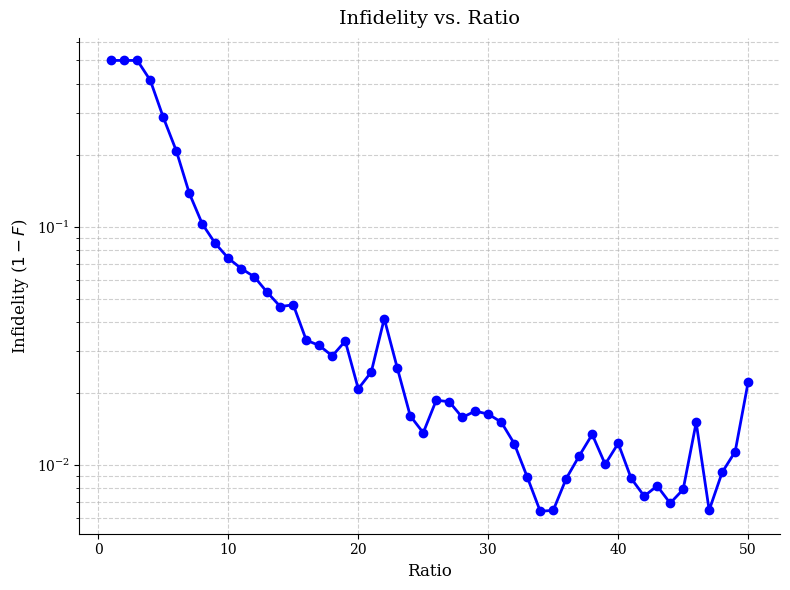

In [20]:
log_infidelities = [1 - i for i in maximum_fidelities]
plt.figure(figsize=(8, 6))  # Adjust size to fit in a thesis column
plt.plot(ratios, log_infidelities, 'b-', linewidth=2, marker='o', markersize=6)

# --- Professional Styling ---
plt.xlabel('Ratio', fontsize=12, fontfamily='serif')
plt.ylabel('Infidelity ($1 - F$)', fontsize=12, fontfamily='serif')
plt.title('Infidelity vs. Ratio', fontsize=14, fontfamily='serif', pad=10)

# Scientific notation for y-axis
plt.yscale('log')
#plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('$10^{%d}$'))  # LaTeX exponents

# Grid and ticks
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.xticks(fontsize=10, fontfamily='serif')
plt.yticks(fontsize=10, fontfamily='serif')

# Adjust spines (remove top/right borders)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()  # Prevent label clipping
plt.show()

In [ ]:
for i in ratios:
    print(i, maximum_fidelities[i-1])

In [10]:
import csv
import numpy as np

def save_plot_data_to_csv(x_data, y_data, filename='plot_data.csv', headers=None):
    """
    Saves two lists/arrays to a CSV file for plotting.
    
    Args:
        x_data (list/array): X-axis values (e.g., time steps)
        y_data (list/array): Y-axis values (e.g., fidelity)
        filename (str): Output CSV filename
        headers (list): Column headers (e.g., ["Time", "Fidelity"])
    """
    # Ensure inputs are numpy arrays
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    
    # Verify equal lengths
    if len(x_data) != len(y_data):
        raise ValueError("x_data and y_data must have the same length")
    
    # Default headers
    if headers is None:
        headers = ["Time_step", "Fidelity"]
    
    # Write to CSV
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(headers)  # Write header
        writer.writerows(zip(x_data, y_data))  # Write data rows
    
    print(f"Data saved to {filename}")
    print(f"First 5 rows:\n{headers[0]}\t{headers[1]}")
    for x, y in zip(x_data[:5], y_data[:5]):
        print(f"{x:.4f}\t{y:.4f}")


    


In [21]:
# Example usage
if __name__ == "__main__":
    # Sample data (replace with your actual lists)
    time_steps = ratios
    fidelity_values = log_infidelities
    # Save to CSV with custom headers
    save_plot_data_to_csv(
        x_data=time_steps,
        y_data=fidelity_values,
        filename="data_files/final_parameters/J_vs_lambda_ghz.csv",
        headers=["Ratio", "Infidelity"]
    )

Data saved to data_files/final_parameters/J_vs_lambda_ghz.csv
First 5 rows:
Ratio	Infidelity
1.0000	0.5000
2.0000	0.5000
3.0000	0.5000
4.0000	0.4122
5.0000	0.2881


In [3]:
def read_plot_data_from_csv(filename):
    """Reads x and y data from a CSV file into two separate lists.
    
    Args:
        filename (str): Path to the CSV file
        
    Returns:
        tuple: (x_data, y_data) as two lists
    """
    x_data = []
    y_data = []
    
    with open(filename, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        next(csv_reader)  # Skip the header row
        for row in csv_reader:
            if len(row) >= 2:  # Ensure there are at least two columns
                x_data.append(float(row[0]))
                y_data.append(float(row[1]))
    
    return x_data, y_data

In [11]:
def plot_ratios(x_data, y_data, log_scale = "True"):    
    plt.figure(figsize=(8, 6))  # Adjust size to fit in a thesis column
    plt.plot(x_data, y_data, 'b-', linewidth=2, marker='o', markersize=6)

    # --- Professional Styling ---
    plt.xlabel('Ratio', fontsize=12, fontfamily='serif')
    plt.ylabel('Infidelity ($1 - F$)', fontsize=12, fontfamily='serif')
    plt.title('Infidelity vs. Ratio', fontsize=14, fontfamily='serif', pad=10)

    # Scientific notation for y-axis
    if log_scale == "True":
        plt.yscale('log')
    #plt.gca().yaxis.set_major_formatter(plt.FormatStrFormatter('$10^{%d}$'))  # LaTeX exponents

    # Grid and ticks
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.xticks(fontsize=10, fontfamily='serif')
    plt.yticks(fontsize=10, fontfamily='serif')

    # Adjust spines (remove top/right borders)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.tight_layout()  # Prevent label clipping
    plt.show()

In [12]:
ratio_1, values_1 = read_plot_data_from_csv("data_files/final_parameters/J_vs_lambda_1.csv")
ratio_plus, values_plus = read_plot_data_from_csv("data_files/final_parameters/J_vs_lambda_+.csv")
ratio_psi, values_psi = read_plot_data_from_csv("data_files/final_parameters/J_vs_lambda_psi.csv")
ratio_ghz, values_ghz = read_plot_data_from_csv("data_files/final_parameters/J_vs_lambda_ghz.csv")



In [13]:
l = 0.1363

j_1 = [ratio*l for ratio in ratio_1]
j_plus = [ratio*l for ratio in ratio_plus]
j_psi = [ratio*l for ratio in ratio_psi]
j_ghz = [ratio*l for ratio in ratio_ghz]

plot_axis_1 = [l**2/j**2 for j in j_1]
plot_axis_plus = [l**2/j**2 for j in j_plus]
plot_axis_psi = [l**2/j**2 for j in j_psi]
plot_axis_ghz= [l**2/j**2 for j in j_ghz]

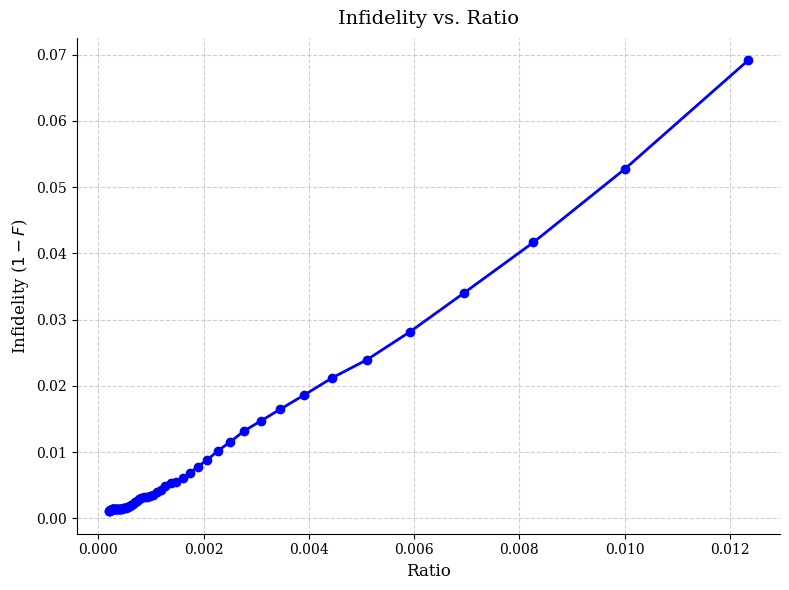

In [29]:
plot_ratios(plot_axis_1[8:], values_1[8:], log_scale= "False")

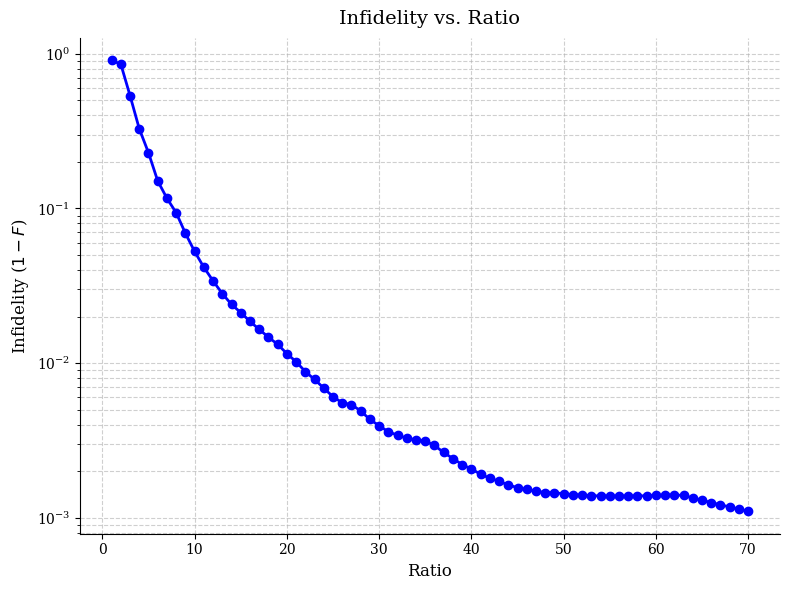

In [30]:
plot_ratios(ratio_1, values_1[:], log_scale= "True")

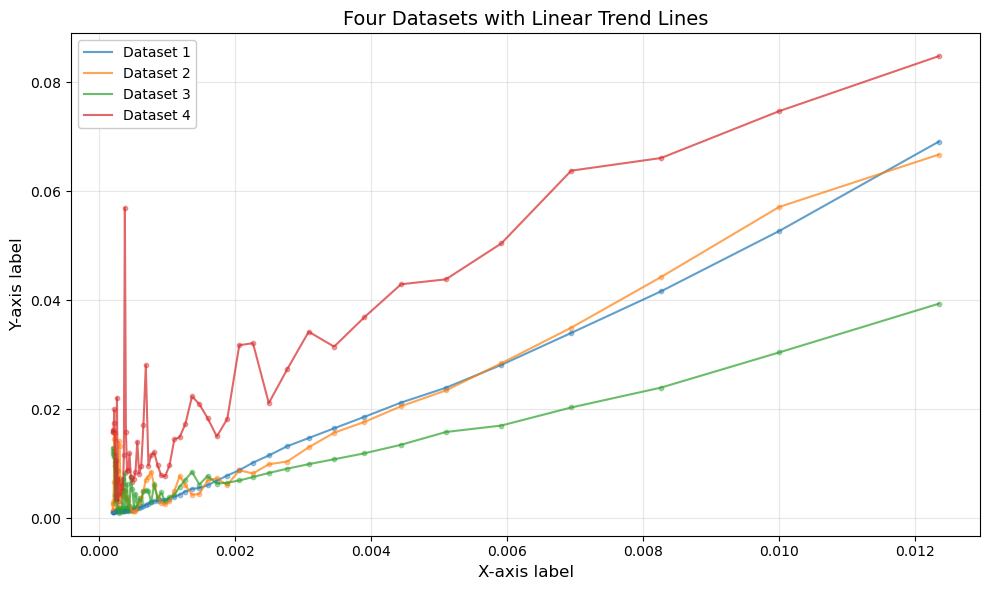

In [31]:
# Generate sample data (replace with your actual data)
# Colors for each line
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
labels = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4']

plt.figure(figsize=(10, 6))
x = plot_axis_1[8:]
# Plot each dataset and its trend line
for i, (y, label, color) in enumerate(zip([values_1[8:], values_plus[8:], values_psi[8:], values_ghz[8:]], labels, colors)):
    # Plot original data
    plt.scatter(x, y, color=color, s=10, alpha=0.4, label=f'_nolegend_')
    plt.plot(x, y, color=color, label=label, linewidth=1.5, alpha=0.7)
    
    # Calculate linear trend line (1st degree polynomial)
    coeffs = np.polyfit(x, y, 1)
    trend_line = np.poly1d(coeffs)
    y_trend = trend_line(x)
    
    # Calculate R-squared
    #r2 = r2_score(y, y_trend)
    r2 = 1
    
    # Plot trend line
    # plt.plot(x, y_trend, color=color, linestyle='--', linewidth=2,
    #          label=f'{label} trend (R² = {r2:.3f})')

# Customize plot
plt.xlabel('X-axis label', fontsize=12)
plt.ylabel('Y-axis label', fontsize=12)
plt.title('Four Datasets with Linear Trend Lines', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, framealpha=1)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:17: SyntaxWarning: invalid escape sequence '\l'
C:\Users\User\AppData\Local\Temp\ipykernel_19996\1208131636.py:4: SyntaxWarning: invalid escape sequence '\p'
  labels = ['$|1>$', '$|+>$', '$|\psi^+>$', '$|GHZ>_3$']
C:\Users\User\AppData\Local\Temp\ipykernel_19996\1208131636.py:17: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$J/\lambda$', fontsize=12)


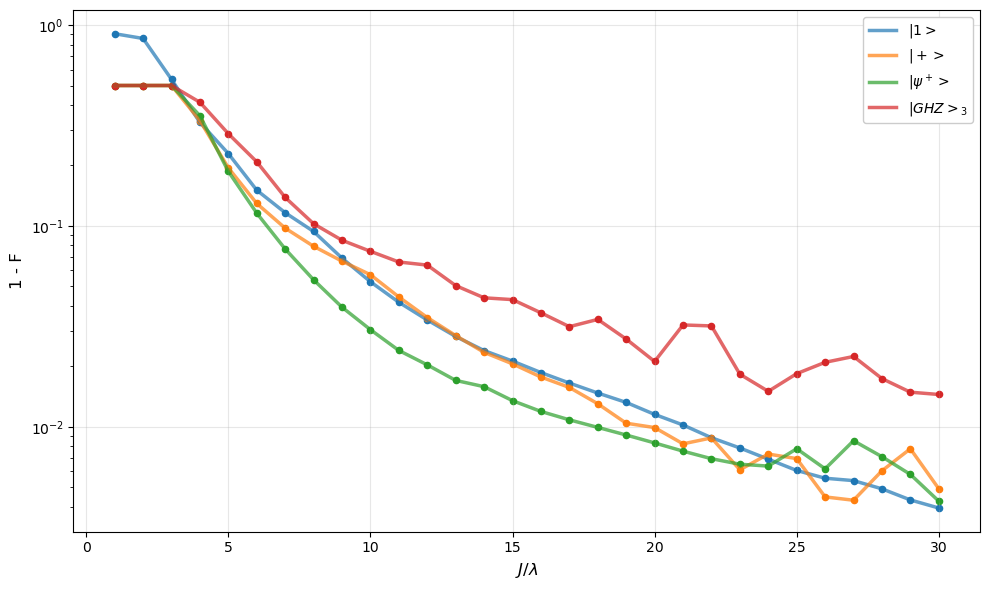

In [32]:
# Generate sample data (replace with your actual data)
# Colors for each line
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
labels = ['$|1>$', '$|+>$', '$|\psi^+>$', '$|GHZ>_3$']

plt.figure(figsize=(10, 6))
x = ratio_1[:30]
# Plot each dataset and its trend line
for i, (y, label, color) in enumerate(zip([values_1[:30], values_plus[:30], values_psi[:30], values_ghz[:30]], labels, colors)):
    # Plot original data
    plt.scatter(x, y, color=color, s=20, alpha=1, label=f'_nolegend_')
    plt.plot(x, y, color=color, label=label, linewidth=2.5, alpha=0.7)


# Customize plot
plt.yscale('log')
plt.xlabel('$J/\lambda$', fontsize=12)
plt.ylabel('1 - F', fontsize=12)
plt.title('', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10, framealpha=1)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [16]:
def plot_ratios_trend(x_data, y_data, log_scale=True, show_trend=True, save_path=None):
    """Create publication-quality plot of error ratios with trend line."""
    plt.figure(figsize=(8, 6), dpi=300)  # High resolution for thesis
    
    # Create a figure with constrained layout
    fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
    
    # Plot original data with improved marker styling
    ax.plot(x_data, y_data, 'b-', linewidth=2, marker='o', markersize=6, 
            markeredgecolor='k', markeredgewidth=0.5, label='Simulated data')
    
    # Calculate and plot trend line if requested
    if show_trend:
        # Linear regression using numpy
        coeffs = np.polyfit(x_data, y_data, 1)
        trend_line = np.poly1d(coeffs)
        y_trend = trend_line(x_data)
        
        # Calculate R-squared
        y_mean = np.mean(y_data)
        ss_tot = np.sum((y_data - y_mean)**2)
        ss_res = np.sum((y_data - y_trend)**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        # Plot trend line with improved styling
        ax.plot(x_data, y_trend, 'r--', linewidth=1.5, 
                label=f'Linear fit ($R^2 = {r_squared:.3f}$)')

    # --- Professional Styling ---
    # Font styling (Times New Roman-like)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    
    # Axis labels with requested font sizes
    ax.set_xlabel(r'$(\lambda/J)^2$', fontsize=15, labelpad=10)
    ax.set_ylabel('$1 - F$', fontsize=15, labelpad=10)
    
    # Title with requested font size
    ax.set_title('Error vs. Ratio $\lambda/J$', fontsize=16, pad=12)
    
    # Scientific notation for y-axis if log scale
    if log_scale:
        ax.set_yscale('log')
        # Format log scale ticks properly
        from matplotlib.ticker import LogFormatter
        ax.yaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
    
    # Tick parameters
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    
    # Grid styling
    ax.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.5)
    
    # Spine styling - remove top/right, adjust others
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_linewidth(0.8)
        ax.spines[spine].set_color('black')
    
    # Legend with professional styling
    if show_trend:
        legend = ax.legend(fontsize=12, frameon=True, 
                          framealpha=1, edgecolor='k',
                          loc='upper left' if log_scale else 'best')
        legend.get_frame().set_linewidth(0.8)
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        plt.savefig(save_path.replace('.pdf', '.png'), format='png', 
                   bbox_inches='tight', dpi=300)
    
    plt.show()

<>:39: SyntaxWarning: invalid escape sequence '\l'
<>:39: SyntaxWarning: invalid escape sequence '\l'
C:\Users\User\AppData\Local\Temp\ipykernel_24872\3363383848.py:39: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title('Error vs. Ratio $\lambda/J$', fontsize=16, pad=12)


In [ ]:
def plot_ratios_trend_slope(x_data, y_data, log_scale=True, show_trend=True, save_path=None):
    """Create publication-quality plot of error ratios with trend line."""
    plt.figure(figsize=(8, 6), dpi=300)  # High resolution for thesis
    
    # Create a figure with constrained layout
    fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
    
    # Plot original data with improved marker styling
    ax.plot(x_data, y_data, 'b-', linewidth=2, marker='o', markersize=6, 
            markeredgecolor='k', markeredgewidth=0.5, label='Simulated data')
    
    # Calculate and plot trend line if requested
    if show_trend:
        # Linear regression using numpy
        coeffs = np.polyfit(x_data, y_data, 1)
        slope = coeffs[0]
        intercept = coeffs[1]
        trend_line = np.poly1d(coeffs)
        y_trend = trend_line(x_data)
        
        # Plot trend line with improved styling
        ax.plot(x_data, y_trend, 'r--', linewidth=1.5, 
                label=f'Linear fit (α = {slope:.3f})')

    # --- Professional Styling ---
    # Font styling (Times New Roman-like)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    
    # Axis labels with requested font sizes
    ax.set_xlabel(r'$log(J/\lambda)$', fontsize=15, labelpad=10)
    ax.set_ylabel('$\log(1 - F)$', fontsize=15, labelpad=10)
    
    # Title with requested font size
    ax.set_title('Error vs. Ratio $J/\lambda$', fontsize=16, pad=12)
    
    # Scientific notation for y-axis if log scale
    if log_scale:
        ax.set_yscale('log')
        # Format log scale ticks properly
        from matplotlib.ticker import LogFormatter
        ax.yaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))
    
    # Tick parameters
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    
    # Grid styling
    ax.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.5)
    
    # Spine styling - remove top/right, adjust others
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_linewidth(0.8)
        ax.spines[spine].set_color('black')
    
    # Legend with professional styling
    if show_trend:
        legend = ax.legend(fontsize=12, frameon=True, 
                          framealpha=1, edgecolor='k',
                          loc='upper left' if log_scale else 'best')
        legend.get_frame().set_linewidth(0.8)
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        plt.savefig(save_path.replace('.pdf', '.png'), format='png', 
                   bbox_inches='tight', dpi=300)
    
    plt.show()

<>:32: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
<>:32: SyntaxWarning: invalid escape sequence '\l'
<>:35: SyntaxWarning: invalid escape sequence '\l'
C:\Users\User\AppData\Local\Temp\ipykernel_3056\4214574309.py:32: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel('$\log(1 - F)$', fontsize=15, labelpad=10)
C:\Users\User\AppData\Local\Temp\ipykernel_3056\4214574309.py:35: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title('Error vs. Ratio $J/\lambda$', fontsize=16, pad=12)


In [1]:
def plot_ratios_trend_slope_poster(x_data, y_data, log_scale=True, show_trend=True, save_path=None):
    """Create publication-quality plot with complete poster scaling."""
    # Set up professional styling with larger fonts for posters
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    
    # Create larger figure suitable for posters
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300, constrained_layout=True)
    
    # Plot original data with enhanced visibility
    ax.plot(x_data, y_data, 'b-', linewidth=4, marker='o', markersize=12, 
            markeredgecolor='k', markeredgewidth=1.2, label='Simulated data', alpha=0.8)
    
    # Calculate and plot trend line if requested
    if show_trend:
        coeffs = np.polyfit(x_data, y_data, 1)
        slope = coeffs[0]
        intercept = coeffs[1]
        trend_line = np.poly1d(coeffs)
        y_trend = trend_line(x_data)
        
        # Enhanced trend line visibility
        ax.plot(x_data, y_trend, 'r--', linewidth=4, 
                label=f'Linear fit (α = {slope:.3f})', alpha=0.8)

    # --- Complete Poster Styling ---
    # Title and labels (matching reference sizes)
    ax.set_title('Error Scaling with $J/\lambda$ Ratio', fontsize=30, pad=18)
    ax.set_xlabel(r'$\log(J/\lambda)$', fontsize=28, labelpad=14)
    ax.set_ylabel('$\log(1 - F)$', fontsize=28, labelpad=14)
    
    # Log scale with professional formatting
    if log_scale:
        ax.set_yscale('log')
        from matplotlib.ticker import LogFormatter
        ax.yaxis.set_major_formatter(LogFormatter(
            labelOnlyBase=False, 
            minor_thresholds=(2, 0.4)
        ))
    
    # Tick parameters (enhanced visibility)
    ax.tick_params(axis='both', which='major', 
                  labelsize=24, width=2.5, length=10)
    ax.tick_params(axis='both', which='minor', 
                  labelsize=20, width=2, length=6)
    
    # Prominent grid
    ax.grid(True, which='both', linestyle=':', 
           linewidth=1.5, alpha=0.7, color='#555555')
    
    # Legend with professional styling
    if show_trend:
        legend = ax.legend(
            fontsize=20, 
            frameon=True, 
            framealpha=1, 
            edgecolor='k',
            loc='upper left' if log_scale else 'best',
            handlelength=1.8
        )
        legend.get_frame().set_linewidth(1.5)
        legend.get_title().set_fontsize(22)
    
    # Spine styling - professional appearance
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_linewidth(2.5)
        ax.spines[spine].set_color('black')
    
    # Final layout adjustments
    plt.tight_layout(pad=2.5)
    
    # Save figure in publication quality
    if save_path:
        plt.savefig(
            save_path, 
            format='pdf', 
            bbox_inches='tight', 
            dpi=300,
            metadata={'CreationDate': None}
        )
        plt.savefig(
            save_path.replace('.pdf', '.png'), 
            format='png', 
            bbox_inches='tight', 
            dpi=300,
            metadata={'CreationDate': None}
        )
    
    plt.show()

<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:30: SyntaxWarning: invalid escape sequence '\l'
<>:28: SyntaxWarning: invalid escape sequence '\l'
<>:30: SyntaxWarning: invalid escape sequence '\l'
C:\Users\User\AppData\Local\Temp\ipykernel_4068\1856070152.py:28: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title('Error Scaling with $J/\lambda$ Ratio', fontsize=30, pad=18)
C:\Users\User\AppData\Local\Temp\ipykernel_4068\1856070152.py:30: SyntaxWarning: invalid escape sequence '\l'
  ax.set_ylabel('$\log(1 - F)$', fontsize=28, labelpad=14)


In [66]:
print(ratio_1)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0]


C:\Users\User\AppData\Local\Temp\ipykernel_4068\1856070152.py:72: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=2.5)


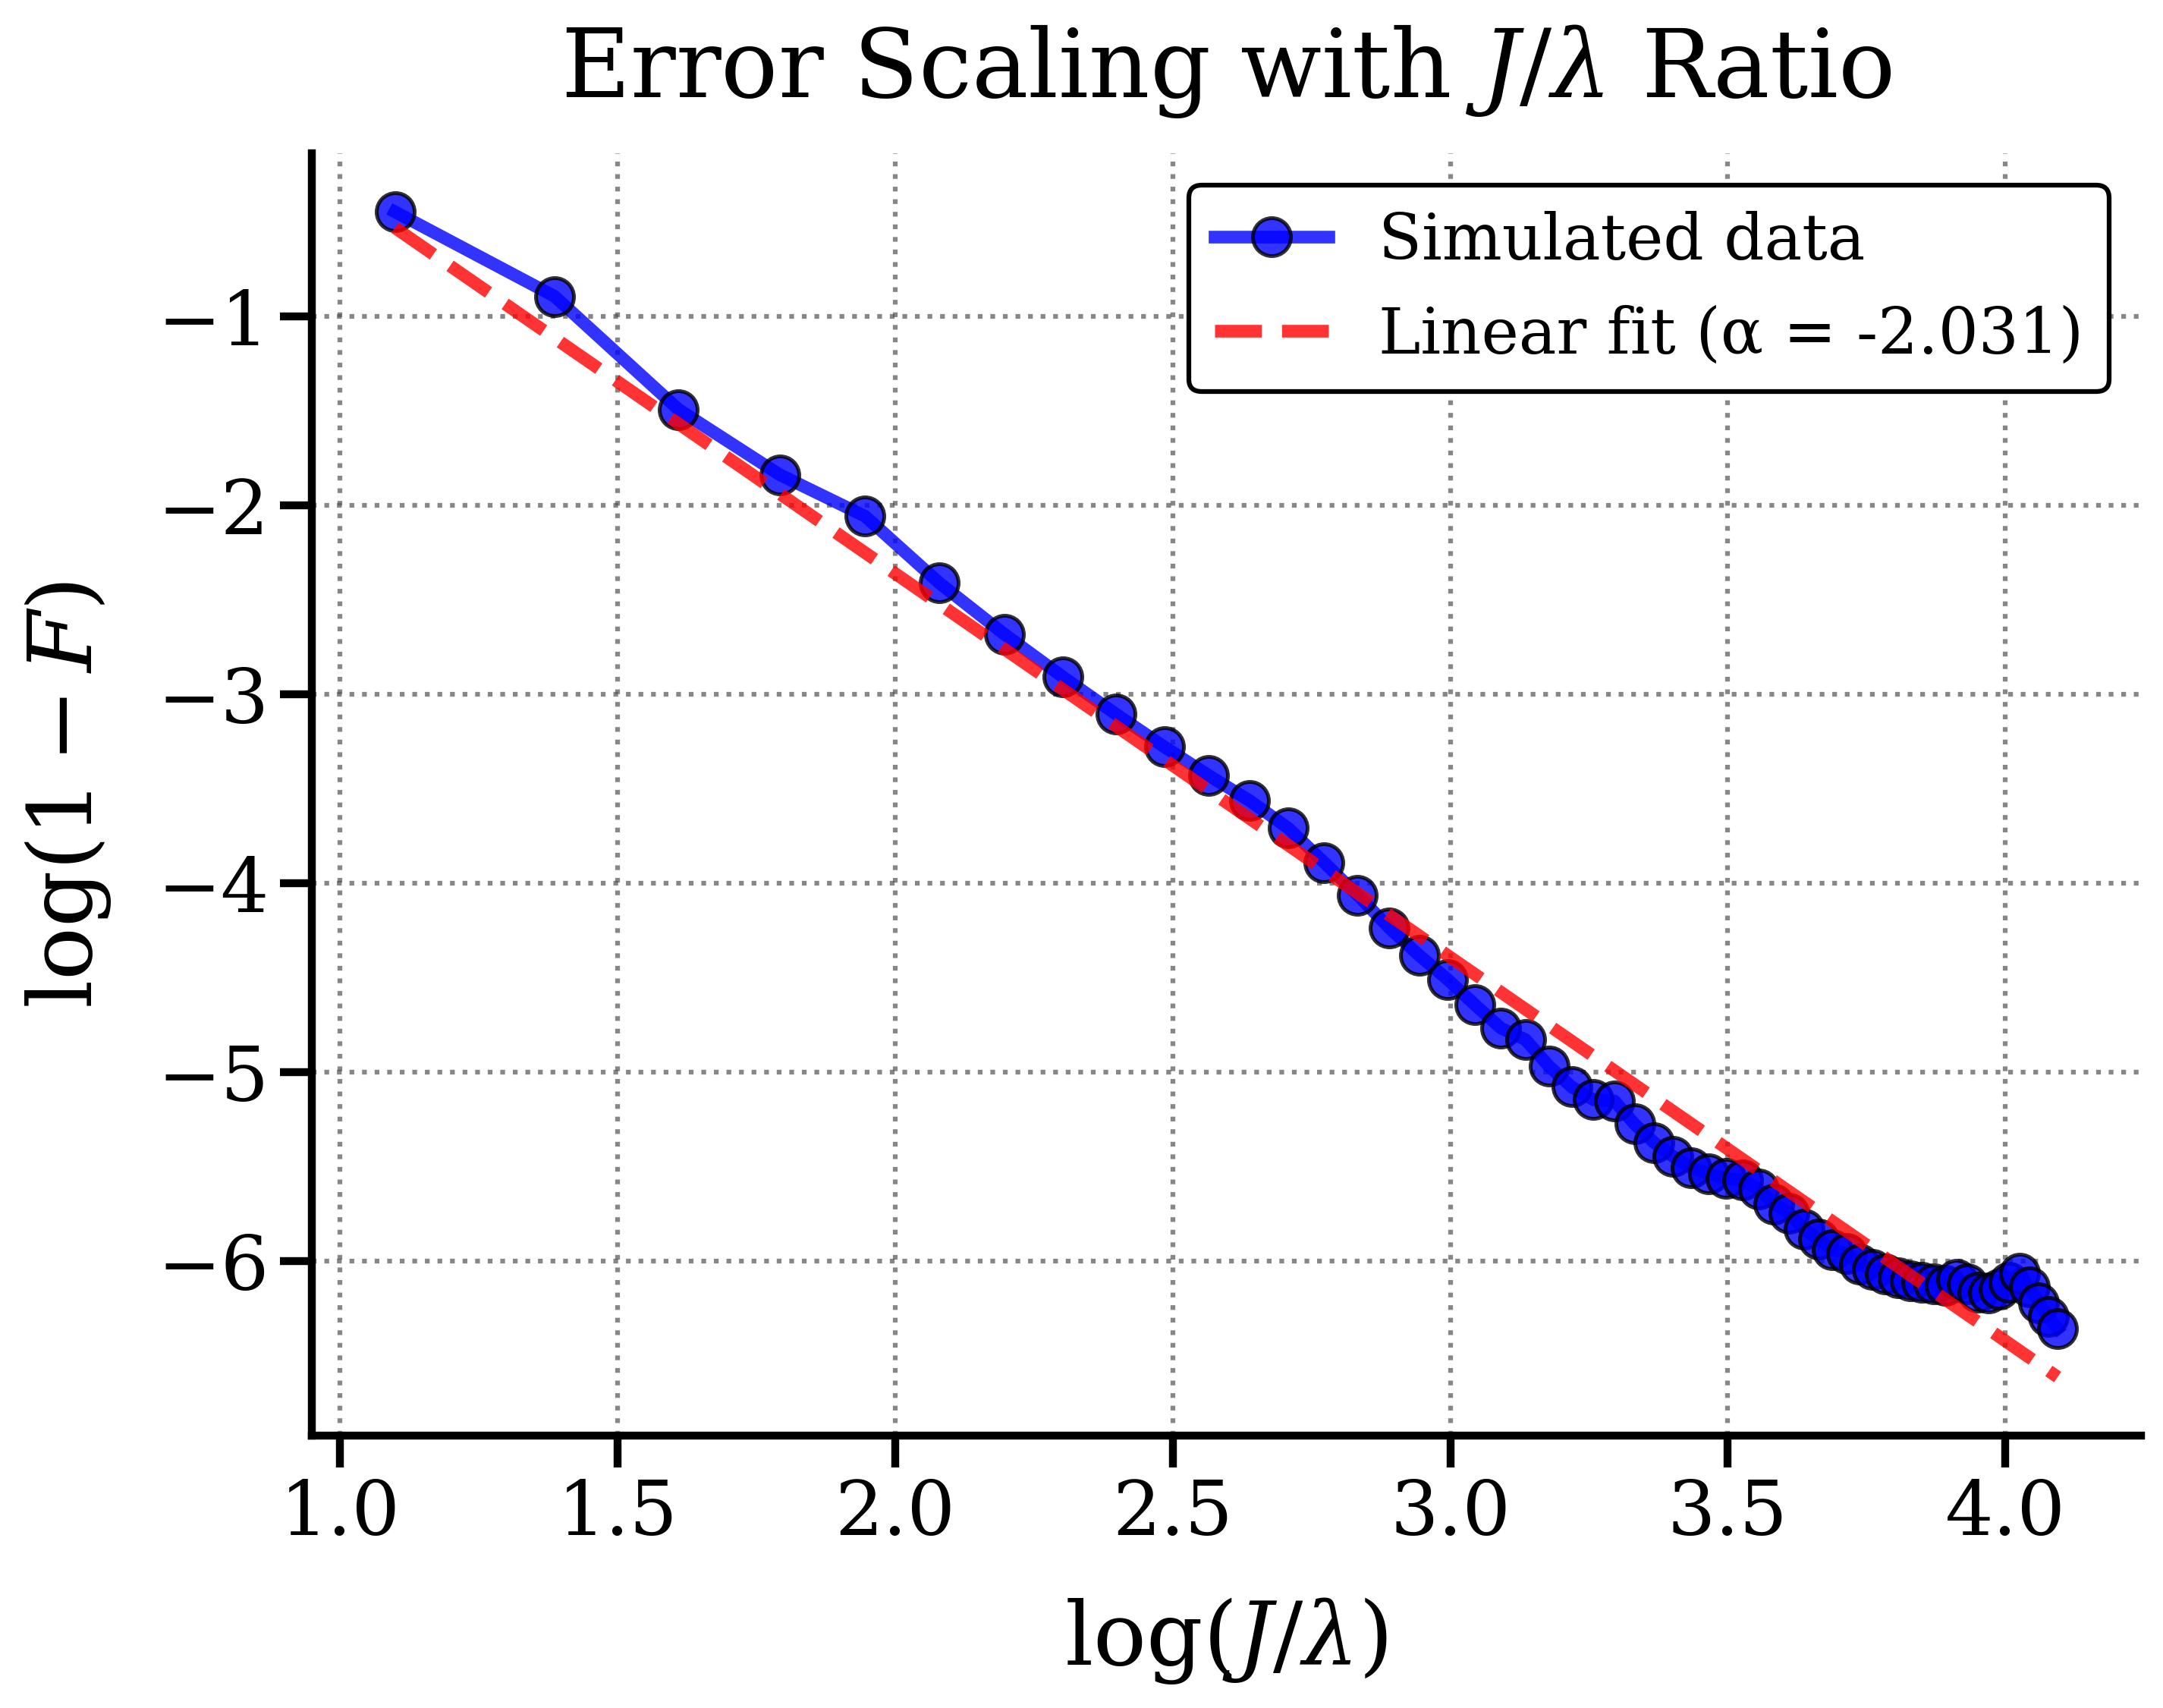

In [13]:
new_ratio_1, new_values_1 = read_plot_data_from_csv("data_files/final_parameters/J_vs_lambda_1.csv")
log_error = [np.log(i) for i in new_values_1]
log_axis = [np.log(i) for i in new_ratio_1]

plot_ratios_trend_slope_poster(
    x_data=log_axis[2:60],
    y_data=log_error[2:60],
    log_scale=False,
    show_trend=True,
    save_path='figures/figures_v3_poster/error_ratio_linear_analysis_final.pdf'
)

In [16]:
def plot_error_ratios(x_data, y_data_list, labels, colors, save_path=None):
    """
    Create publication-quality plot of error ratios for multiple quantum states.
    
    Parameters:
    - x_data: Array of x-values (J/λ ratios)
    - y_data_list: List of arrays containing y-values (1-F) for each state
    - labels: List of labels for each state (LaTeX formatted)
    - colors: List of colors for each state
    - save_path: Optional path to save the figure
    """
    # Create figure with constrained layout
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300, constrained_layout=True)
    
    # Plot each dataset with enhanced styling
    for i, (y_data, label, color) in enumerate(zip(y_data_list, labels, colors)):
        # Plot line and points with improved styling
        ax.plot(x_data, y_data, color=color, linewidth=2.5, alpha=0.7, 
                marker='o', markersize=6, markeredgecolor='k', markeredgewidth=0.5,
                label=label)
    

   # Title with requested font size
    ax.set_title('Error vs. $J/\lambda$ for Test States', fontsize=20, pad=12)

    # --- Professional Styling ---
    # Axis labels with requested font sizes
    ax.set_xlabel(r'$J/\lambda$', fontsize=18, labelpad=10)
    ax.set_ylabel('$1 - F$', fontsize=18, labelpad=10)
    
    # Log scale with proper formatting
    ax.set_yscale('log')
    from matplotlib.ticker import LogFormatter
    ax.yaxis.set_major_formatter(LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.4)))
    
    # Tick parameters
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=12)
    
    # Grid styling
    ax.grid(True, which='both', linestyle=':', linewidth=0.7, alpha=0.5)
    
    # Legend with professional styling
    legend = ax.legend(fontsize=12, frameon=True, framealpha=1, 
                      edgecolor='k', loc='upper right')
    legend.get_frame().set_linewidth(0.8)
    
    # Spine styling - remove top/right, adjust others
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_linewidth(0.8)
        ax.spines[spine].set_color('black')
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        plt.savefig(save_path.replace('.pdf', '.png'), format='png', 
                   bbox_inches='tight', dpi=300)
    
    plt.show()


<>:27: SyntaxWarning: invalid escape sequence '\l'
<>:27: SyntaxWarning: invalid escape sequence '\l'
C:\Users\User\AppData\Local\Temp\ipykernel_3056\809433276.py:27: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title('Error vs. $J/\lambda$ for Test States', fontsize=20, pad=12)


In [18]:
def plot_error_ratios_poster(x_data, y_data_list, labels, colors, save_path=None):
    """
    Create publication-quality plot of error ratios for multiple quantum states.
    Optimized for side-by-side display in posters with larger fonts and thicker lines.
    """
    # Set up professional styling with larger fonts for posters
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['mathtext.fontset'] = 'dejavuserif'
    
    # Create larger figure suitable for posters
    fig, ax = plt.subplots(figsize=(10, 8), dpi=300, constrained_layout=True)
    
    # Plot each dataset with enhanced styling for visibility
    for i, (y_data, label, color) in enumerate(zip(y_data_list, labels, colors)):
        # Thicker lines and larger markers for poster visibility
        ax.plot(x_data, y_data, color=color, linewidth=4, alpha=0.8, 
                marker='o', markersize=10, markeredgecolor='k', markeredgewidth=1,
                label=label)

    # --- Poster-Optimized Styling ---
    # Larger title and labels
    ax.set_title('Error vs. $J/\lambda$ for Test States', fontsize=28, pad=15)
    ax.set_xlabel(r'$J/\lambda$', fontsize=26, labelpad=12)
    ax.set_ylabel('$1 - F$', fontsize=26, labelpad=12)
    
    # Log scale with proper formatting
    ax.set_yscale('log')
    from matplotlib.ticker import LogFormatter
    ax.yaxis.set_major_formatter(LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 0.4)))
    
    # Larger ticks
    ax.tick_params(axis='both', which='major', labelsize=22, width=2, length=8)
    ax.tick_params(axis='both', which='minor', labelsize=18, width=1.5, length=6)
    
    # More prominent grid
    ax.grid(True, which='both', linestyle=':', linewidth=1.2, alpha=0.6)
    
    # Larger legend with better visibility
    legend = ax.legend(fontsize=18, frameon=True, framealpha=1, 
                      edgecolor='k', loc='upper right', handlelength=1.5)
    legend.get_frame().set_linewidth(1.2)
    
    # Thicker spines
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_linewidth(2)
        ax.spines[spine].set_color('black')
    
    # Adjust layout to minimize white space
    plt.tight_layout(pad=2.0)
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, format='pdf', bbox_inches='tight', dpi=300)
        plt.savefig(save_path.replace('.pdf', '.png'), format='png', 
                   bbox_inches='tight', dpi=300)
    
    plt.show()

<>:22: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\l'
C:\Users\User\AppData\Local\Temp\ipykernel_3056\1592983365.py:22: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title('Error vs. $J/\lambda$ for Test States', fontsize=28, pad=15)


C:\Users\User\AppData\Local\Temp\ipykernel_3056\1592983365.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=2.0)


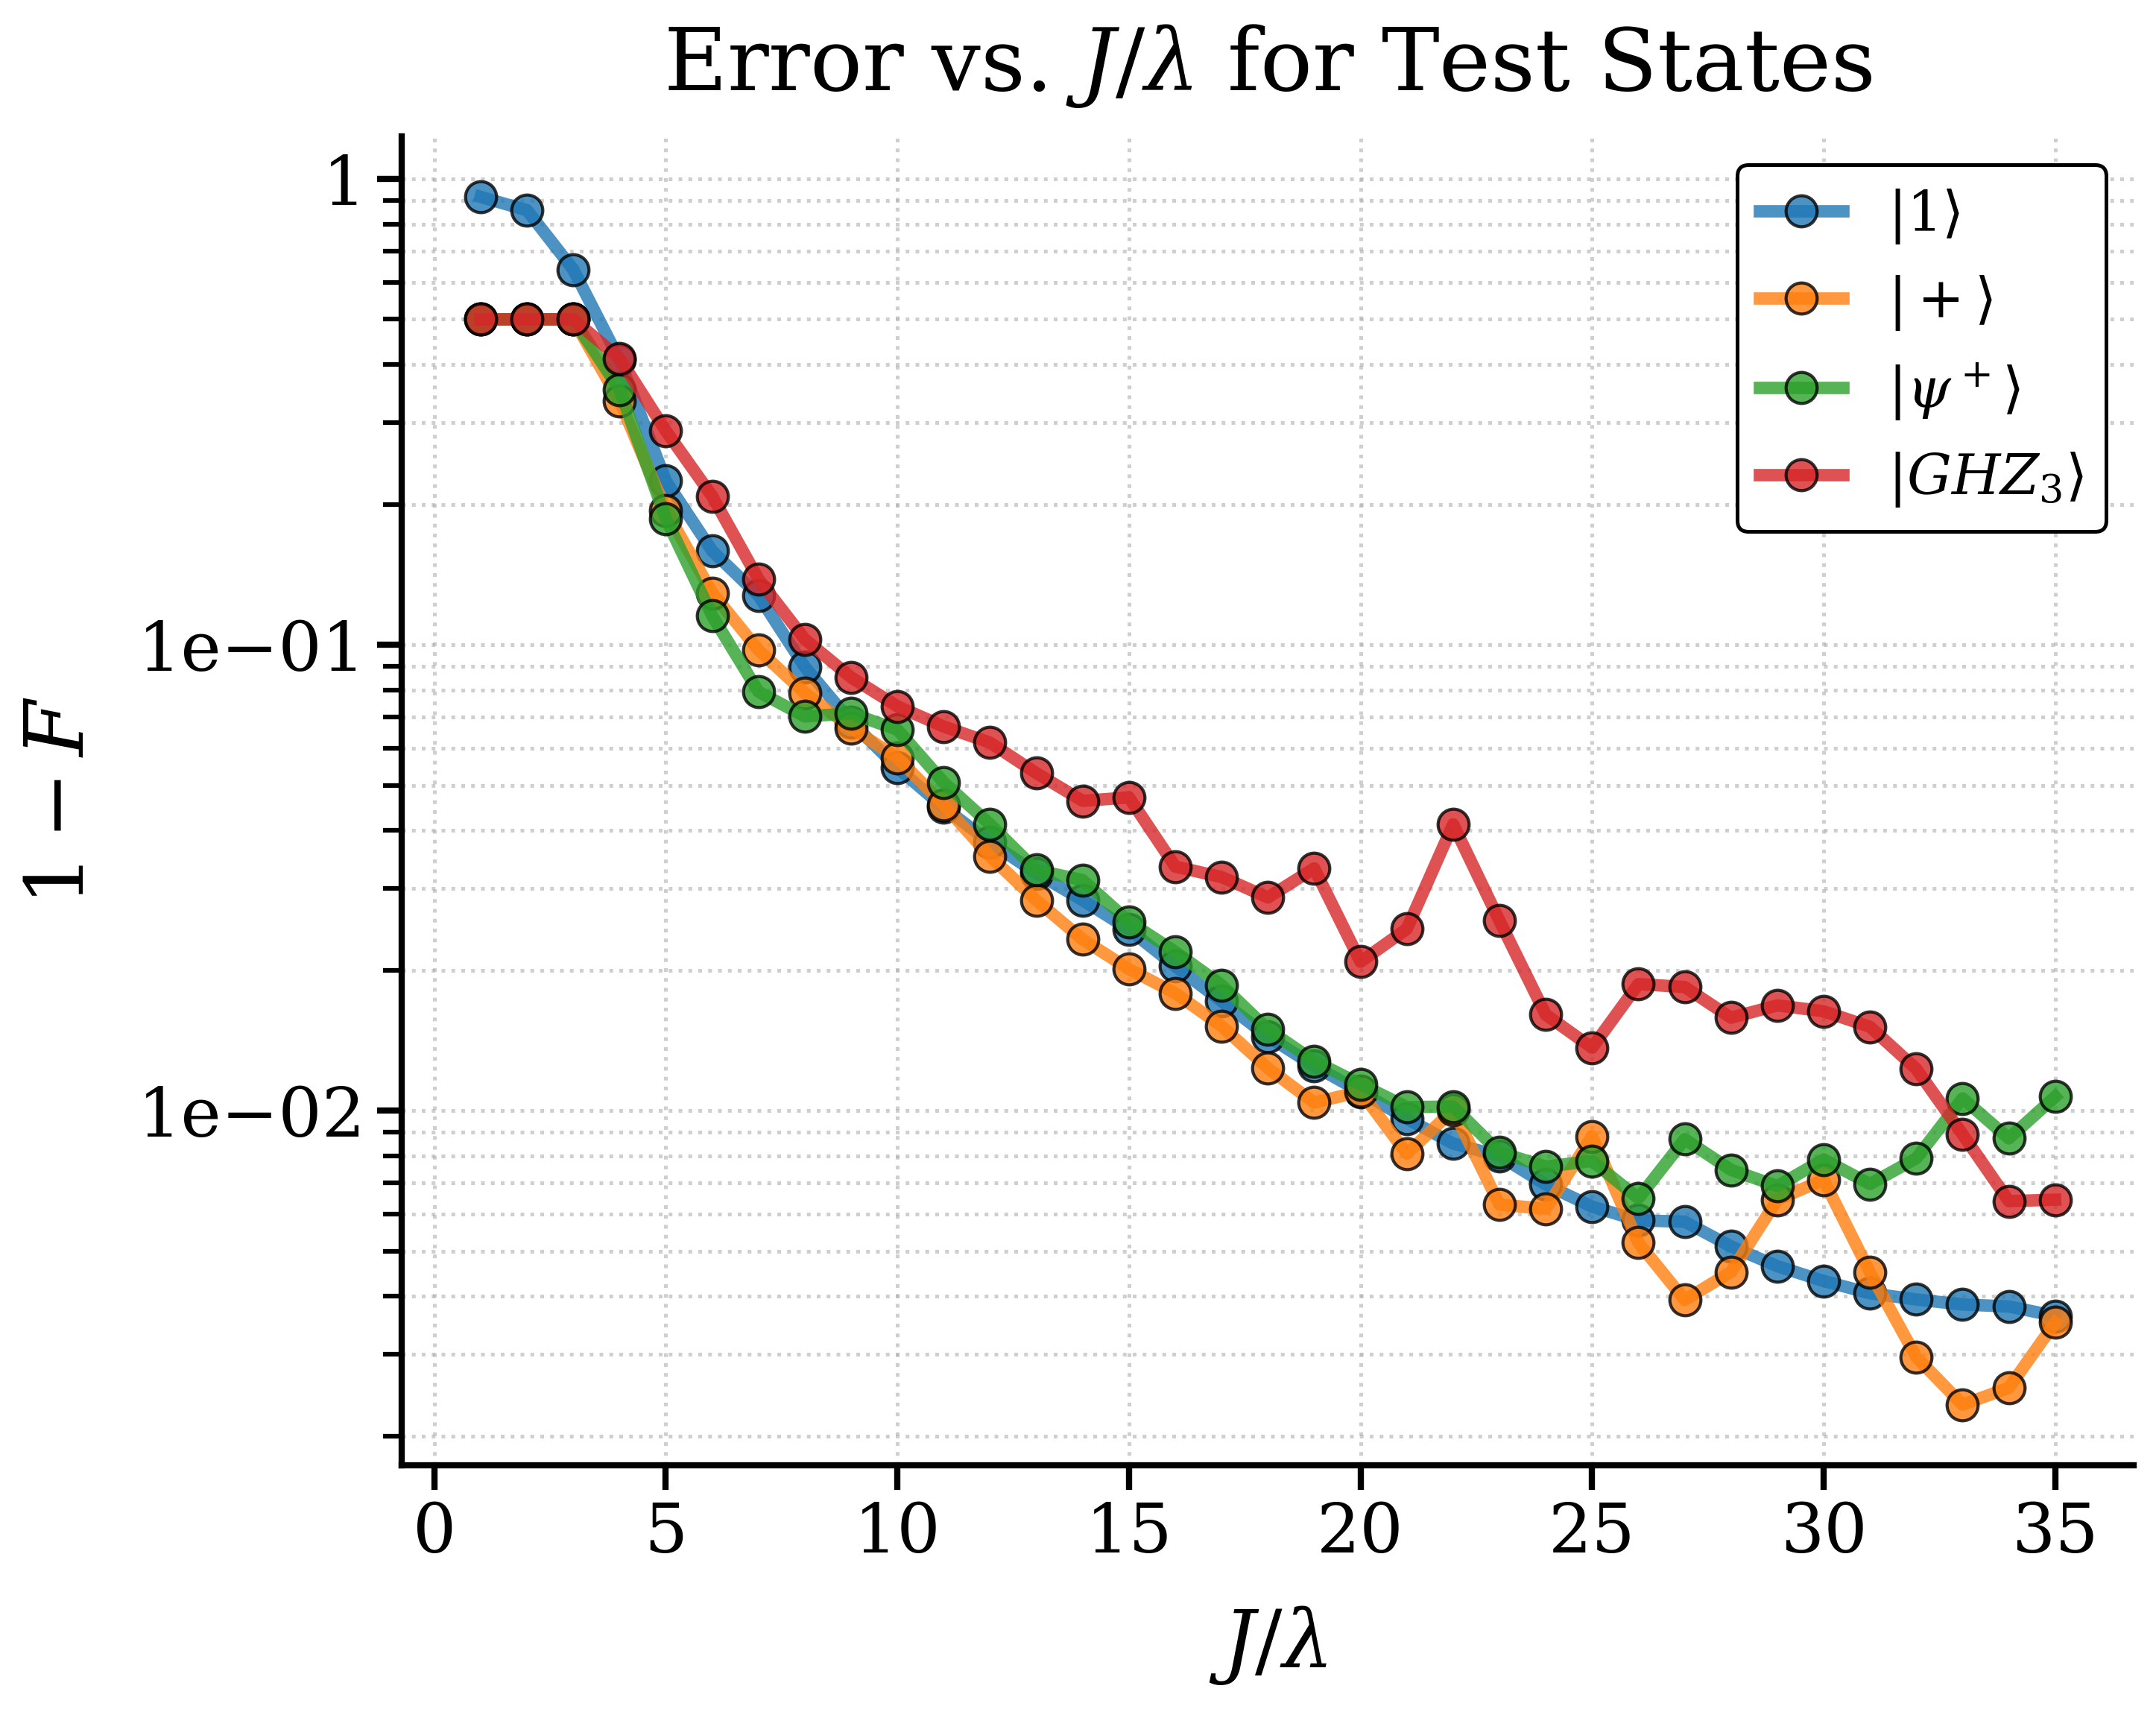

In [19]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Maintain original color scheme
labels = [r'$|1\rangle$', r'$|+\rangle$', r'$|\psi^+\rangle$', r'$|GHZ_3\rangle$']
max_index = 35
# Replace with your actual data
x_data = ratio_1[:max_index]
y_data_list = [values_1[:max_index], values_plus[:max_index], values_psi[:max_index], values_ghz[:max_index]]

plot_error_ratios_poster(
    x_data=x_data,
    y_data_list=y_data_list,
    labels=labels,
    colors=colors,
    save_path='figures/figures_v3_poster/error_ratios_comparison_new_parameters.pdf'
)